### PREPARATIONS

In [1]:
##### LIBRARIES

import numpy as np
import pandas as pd

import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, models, datasets
from torch.utils.data import Dataset
from torch.autograd import Variable

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold

from tqdm import tqdm_notebook as tqdm
from functools import partial
import scipy as sp

import random
import time
import sys
import os
import math

package_path = '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master'
sys.path.append(package_path)
from efficientnet_pytorch import EfficientNet

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
##### CUSTOM MODULES

sys.path.append('../codes')
from preprocessing import *
from data import EyeTestData
from utilities import seed_everything
from model import init_model

In [3]:
##### GPU CHECK

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available. Training on CPU...')
    device = torch.device('cpu')
else:
    print('CUDA is available. Training on GPU...')
    device = torch.device('cuda:0')

CUDA is not available. Training on CPU...


In [4]:
##### RANDOMNESS

# seed function
def seed_everything(seed = 23):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
# set seed
seed = 23
seed_everything(seed)

# DATA IMPORT

In [5]:
##### CHECK DIMENSIONS

# import data
test = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

# check shape
print(test.shape)

(1928, 2)


In [6]:
##### TRANSFORMATIONS

# parameters
batch_size = 25
image_size = 256

# test transformations
test_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.ToTensor()
                                 ])

In [7]:
##### DATA LOADER

# create dataset
test_dataset = EyeTestData(data      = test, 
                           directory = '../input/aptos2019-blindness-detection/test_images',
                           transform = test_trans)

# create data loader
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size  = batch_size, 
                                          shuffle     = False, 
                                          num_workers = 4)

# DATA CHECK

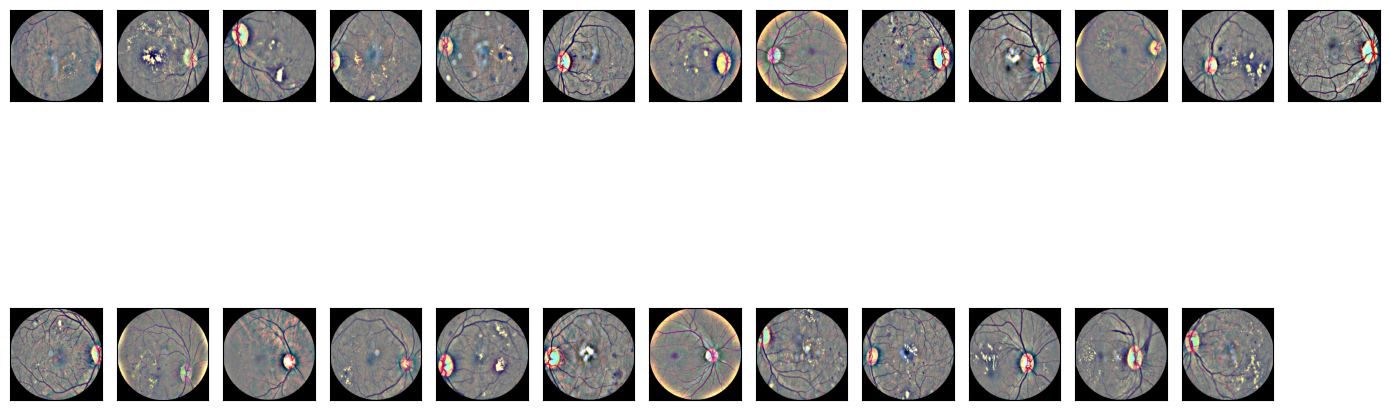

In [9]:
# Display images
for batch_i, data in enumerate(test_loader):
    # Extract data
    inputs = data['image']
    
    # Create plot
    fig = plt.figure(figsize=(14, 7))
    n_cols = len(inputs) // 2 if len(inputs) % 2 == 0 else (len(inputs) // 2 + 1)  # Ensure n_cols is an integer
    for i in range(len(inputs)):
        ax = fig.add_subplot(2, n_cols, i + 1, xticks=[], yticks=[])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))  # Convert from CHW to HWC
    
    plt.tight_layout()  # Adjust layout
    plt.show()  # Show the plot
    break  # Display only the first batch


# MODEL SETUP

In [10]:
##### MODEL ARCHITECTURE

# model name
model_name = 'enet_b4'

# check architecture
model = init_model(train = False, model_name = 'enet_b4')
print(model)

Loaded pretrained weights for efficientnet-b4
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, ke

# INFERENCE LOOP

In [12]:
# Inference Loop

# Validation settings
num_folds = 4
tta_times = 4

# Placeholders
test_preds = np.zeros((len(test), num_folds))
cv_start = time.time()

# Prediction loop
for fold in tqdm(range(num_folds)):
    
    # Load model and send to GPU
    model = init_model(model_name=model_name, train=False)  # Corrected line
    model.load_state_dict(torch.load('../models/model_{}_fold{}.bin'.format(model_name, fold + 1)))
    model = model.to(device)
    model.eval()
    
    # Placeholder for predictions
    fold_preds = np.zeros((len(test), 1))
    
    # Loop through batches with TTA
    for _ in range(tta_times):
        for batch_i, data in enumerate(test_loader):
            inputs = data['image']
            inputs = inputs.to(device, dtype=torch.float)
            preds = model(inputs).detach()
            _, class_preds = preds.topk(1)
            fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] += class_preds.cpu().numpy()
    
    fold_preds = fold_preds / tta_times  # Average predictions
    
    # Aggregate predictions
    test_preds[:, fold] = fold_preds.reshape(-1)

# Print performance
test_preds_df = pd.DataFrame(test_preds.copy())
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))


  0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained weights for efficientnet-b4
Loaded pretrained weights for efficientnet-b4
Loaded pretrained weights for efficientnet-b4
Loaded pretrained weights for efficientnet-b4
Finished in 54.90 minutes


---------------------------------------------
PREDICTIONS
---------------------------------------------
     0    1    2    3
0  1.5  2.0  2.0  2.0
1  2.0  2.0  2.0  2.0
2  2.0  2.0  2.0  2.0
3  2.0  2.0  2.0  2.0
4  2.0  2.0  2.0  2.0
---------------------------------------------
CORRELATION MATRIX
---------------------------------------------
        0       1       2       3
0  1.0000  0.9637  0.9619  0.9235
1  0.9637  1.0000  0.9567  0.9298
2  0.9619  0.9567  1.0000  0.9500
3  0.9235  0.9298  0.9500  1.0000
Mean correlation = 0.9607
---------------------------------------------
SUMMARY STATS
---------------------------------------------
                 0            1            2            3
count  1928.000000  1928.000000  1928.000000  1928.000000
mean      1.642376     1.623963     1.691260     1.742220
std       0.936916     0.931000     0.955968     0.920245
min       0.000000     0.000000     0.000000     0.000000
25%       1.250000     1.000000     1.500000     2.000000
50%

<Axes: ylabel='Density'>

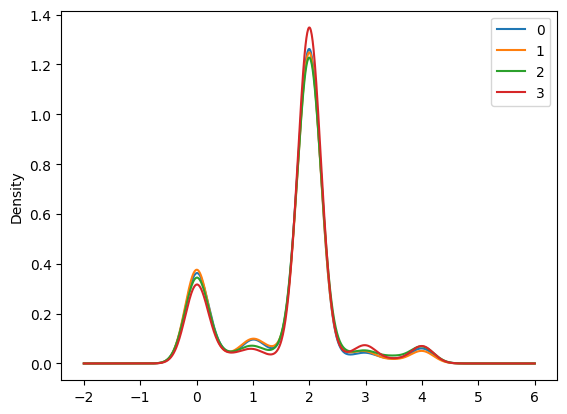

In [13]:
##### SUMMARIZE PREDICTIONS

# show predictions
print('-' * 45)
print('PREDICTIONS')
print('-' * 45)
print(test_preds_df.head())

# show correlation
print('-' * 45)
print('CORRELATION MATRIX')
print('-' * 45)
print(np.round(test_preds_df.corr(), 4))
print('Mean correlation = ' + str(np.round(np.mean(np.mean(test_preds_df.corr())), 4)))

# show stats
print('-' * 45)
print('SUMMARY STATS')
print('-' * 45)
print(test_preds_df.describe())

# show prediction distribution
print('-' * 45)
print('ROUNDED PREDICTIONS')
print('-' * 45)
for f in range(num_folds):
    print(np.round(test_preds_df[f]).astype('int').value_counts(normalize = True))
    print('-' * 45)

# plot densities
test_preds_df.plot.kde()

In [14]:
##### AGGREGATE PREDICTIONS

# extract prediction
test_preds = test_preds_df.mean(axis = 1).values

# SAVE PREDICTIONS

In [15]:
##### THRESHOLD OPTIMIZER

# load cutoffs
coef = [0.5, 1.75, 2.25, 3.5]

# rounding
for i, pred in enumerate(test_preds):
    if pred < coef[0]:
        test_preds[i] = 0
    elif pred >= coef[0] and pred < coef[1]:
        test_preds[i] = 1
    elif pred >= coef[1] and pred < coef[2]:
        test_preds[i] = 2
    elif pred >= coef[2] and pred < coef[3]:
        test_preds[i] = 3
    else:
        test_preds[i] = 4

In [16]:
##### EXPORT CSV

# construct data frame
sub = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
sub['diagnosis'] = test_preds.astype('int')

# save predictions
sub.to_csv('../submissions/submission.csv', index = False)

In [17]:
##### CHECK DISTRIBUTION

# print frequencies
sub['diagnosis'].value_counts(normalize = True)

diagnosis
2    0.631743
0    0.189315
1    0.076245
3    0.070021
4    0.032676
Name: proportion, dtype: float64